In [155]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math

## Load Data

In [156]:
from pathlib import Path

data_dirs = [Path("./"), Path("../")]

tf = transforms.Compose([
    # 0.1307 is the mean of the MNIST dataset, 0.3081 is the standard deviation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), 
])

for data_dir in data_dirs:
    if (data_dir / "MNIST").exists():
        raw_train_data = datasets.MNIST(data_dir, train=True, transform=tf)
        raw_test_data = datasets.MNIST(data_dir, train=False, transform=tf)
        break
else:
    raw_train_data = datasets.MNIST("./", train=True, download=True, transform=tf)
    raw_test_data = datasets.MNIST("./", train=False, download=True, transform=tf)
    

g = torch.Generator().manual_seed(42)


## Preprocessing

### Patch


In [157]:
def patch(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    divide image into non-overlapping patches
    (C, H, W) -> (N, P*P*C) where N = (H/P)*(W/P)
    note: H and W must be divisible by P
    """
    if x.size(-1) % patch_size != 0 or x.size(-2) % patch_size != 0:
        raise ValueError("Height and Width must be divisible by patch_size")
    N = (x.size(-2)//patch_size) * (x.size(-1) // patch_size)
    x = x.unfold(1, patch_size,patch_size).unfold(2, patch_size,patch_size)  # (C, H/P, W/P, P, P)
    x = x.permute(1, 2, 0, 3, 4)  # (H/P, W/P, C, P, P)

    return x.reshape(N, -1)

In [158]:
class PatchDataset(Dataset):
    def __init__(self, dataset, patch_size):
        self.labels = []
        self.img_patches = []
        for img, label in dataset:
            self.labels.append(label)
            self.img_patches.append(patch(img, patch_size))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.img_patches[idx], self.labels[idx])

In [159]:
class ShiftedPatchDataset(Dataset):
    def __init__(self, dataset, patch_size):
        self.patch_size = patch_size
        self.labels = []
        self.patched_features = []
        for img, label in dataset:
            self.labels.append(label)
            self.patched_features.append(self._shifted_patch(img))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.patched_features[idx], self.labels[idx])

    def _shifted_patch(self, x):
        # Shifting and concat
        # (C, H, W) -> (5, C, H, W)
        patch_size = self.patch_size
        p = self.patch_size / 4
        translates = [[0, 0], [p, p],[p,-p],[-p,-p],[-p,p]]
        shifted = torch.stack(
            [ v2.functional.affine(x, 0, translate, 1, [0.0], 0) for translate in translates ],
            dim = 0
        )

        N = (shifted.size(-2)//patch_size) * (shifted.size(-1) // patch_size)

        # (5, C, H, W) -> (N, P*P*C*5)
        x = shifted.unfold(2,patch_size,patch_size).unfold(3,patch_size,patch_size) # (5, C, H/P, W/P, P, P)
        x = x.permute(2, 3, 0, 1, 4, 5) # (H/P, W/P, 5, C, P, P)

        return x.reshape(N, -1)

torch.Size([1, 28, 28])


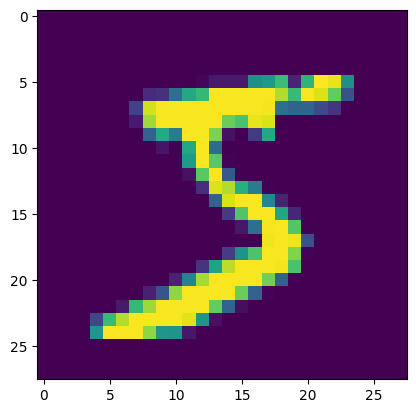

<Figure size 640x480 with 0 Axes>

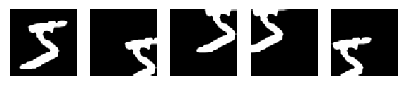

In [160]:
def test():
    inp = raw_train_data[0][0]
    plt.imshow(inp.squeeze(0))
    print(inp.shape)
    p = 28
    class monk:
        patch_size = p
    out = ShiftedPatchDataset._shifted_patch(monk(), inp)
    
    N = out.size(0)
    fig = plt.figure()
    C = 1

    out = out.reshape(N, 5, C, p, p)

    fig = plt.figure(figsize=(5, N))
    for i in range(N):
        for j in range(5):
            ax = fig.add_subplot(N, 5, i * 5 + j + 1)
            ax.axis("off")
            ax.imshow(out[i, j, 0].cpu(), cmap="gray", vmin=0, vmax=1)

test()

tensor(6)


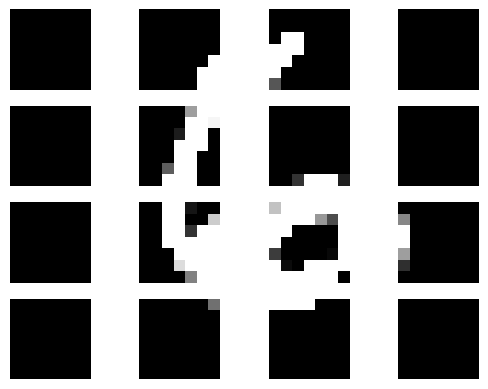

In [161]:
def test_preprocessing():
    p = 7
    train_data = PatchDataset(raw_train_data, p)
    train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
    x_batch, y_batch = next(iter(train_loader))

    x = x_batch[0]
    print(y_batch[0])
    n = int(x.size(0) ** (1/2))
    fig = plt.figure()
    for i in range(x.size(0)):
        fig.add_subplot(n, n, i+1)
        plt.imshow(x[i].reshape(p, p) , cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

test_preprocessing()

## Model

### Tokenization

In [162]:
class Tokenization(nn.Module):
    def __init__(self, patch_dim, emb_dim):
        """
        Tokenization and add CLS token
        (B, N, P*P*C) -> (B, N+1, d)
        patch_dim = P*P*C
        """
        super().__init__()
        self.projection = nn.Linear(patch_dim, emb_dim)
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, 1, emb_dim))

    def forward(self, x:torch.Tensor):
        x = self.projection(x) # (B, N, d)
        cls_token = self.cls_token.expand(x.size(0), -1, -1) # (B, 1, d)
        pos_emb = self.pos_emb.expand(x.size(0), x.size(1) + 1, -1)
        return torch.cat((cls_token, x), dim = 1) + pos_emb

### Shifted Patch Tokenization

In [163]:
class SPT(nn.Module):
    """
    """
    def __init__(self, patch_size, emb_dim):
        pass
        

### Attention

In [164]:
class SelfAttention(nn.Module):
    """
    (B, N+1, d) -> (B, N+1, d_v)
    d_q = d_k = d_v = d here
    note: d_q must equal to d_k in self-attention
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.Q = nn.Linear(emb_dim, emb_dim)
        self.K = nn.Linear(emb_dim, emb_dim)
        self.V = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, x:torch.Tensor):
        R = self.Q(x) @ self.K(x).transpose(-1, -2)
        # (B, N+1, d) @ (B, d, N+1) -> (... N+1, N+1)
        #      Q             K               Q    K
        SA = (
            F.softmax(R / math.sqrt(self.emb_dim), -1) # soft max on K
            @ self.V(x))
        return SA

### Transformer

In [165]:
class Transformer(nn.Module):
    def __init__(self, emb_dim, dropout_p = 0.0):
        super().__init__()
        self.attention = nn.MultiheadAttention(emb_dim, 4, batch_first=True, dropout=dropout_p)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*2),
            nn.GELU(),
            nn.Dropout(dropout_p),
            nn.Linear(emb_dim*2, emb_dim),
            nn.Dropout(dropout_p)
        )
    
    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x, need_weights=False)[0] # get output only
        return x + self.mlp(self.norm2(x))

In [166]:
# ref: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html#using-nn-sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [167]:
class ViT(nn.Module):
    def __init__(self, patch_size, d_model):
        super().__init__()
        self.model = nn.Sequential(
            Tokenization(patch_size**2, d_model), # C == 1 in MNIST
            Transformer(d_model, 0.6),
            Transformer(d_model, 0.6),
            Transformer(d_model, 0.6),
            Transformer(d_model, 0.6),
            # Head
            Lambda(lambda x: x[:,0,:]),
            nn.Linear(d_model, 10)
        )
        
    def forward(self, x):
        return self.model(x)

## Train

In [168]:
import numpy as np
from torch import Tensor

loss_func = F.cross_entropy

def accuracy(input:Tensor, target:Tensor):
    preds = torch.argmax(input, dim=1)
    return (preds == target).float().mean()

In [169]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            total_acc += accuracy(preds, y_batch)
            total_loss += loss_func(preds, y_batch)
    return total_loss / len(loader), total_acc / len(loader)

def fit(model, optimizer, train_loader, val_loader, epochs, device):
    model.to(device)
    for epoch in range(epochs):
        loss_t = 0
        acc_t = 0
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            loss = loss_func(preds, y_batch)
            loss_t += loss
            acc_t += accuracy(preds, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        print(f"epoch {epoch+1} loss (train): {loss_t / len(train_loader):.4f}, accuracy (train): {acc_t / len(train_loader):.4f}", end=" ")
        loss, acc = evaluate(model, val_loader, device)
        print(f"loss: {loss:.4f}, accuracy: {acc:.4f}")


In [170]:
patch_size = 14

In [171]:
train_data = PatchDataset(raw_train_data, patch_size = patch_size)
train_data, val_data = random_split(train_data, [50000, 10000], generator=g)

In [172]:
model = ViT(
    patch_size = patch_size,
    d_model = 64
)

print(next(model.named_modules())[1])
print(f"Params: {sum(p.numel() for p in model.parameters())}")

ViT(
  (model): Sequential(
    (0): Tokenization(
      (projection): Linear(in_features=196, out_features=64, bias=True)
    )
    (1): Transformer(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.6, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.6, inplace=False)
      )
    )
    (2): Transformer(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, e

In [173]:
bs = 32

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs*2, shuffle=True)

inp  = next(iter(train_loader))[0]
print(inp.shape)

out = model(inp)
print(out.shape)


torch.Size([32, 4, 196])
torch.Size([32, 10])


In [ ]:
lr = 0.03
epochs = 100

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.0)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

fit(model, optimizer, train_loader, val_loader, epochs, device)

Save & Test

- ViT
    - 準確率 97% 左右, best: 0.9791 (80 epochs)
    - Architecture:
        - Transformer block x4
            - MHSA, `num_head = 4`
            - MLP
                1. `Linear(emb_dim, emb_dim*2)`,
                2. `GELU`,
                3. `Linear(emb_dim*2, emb_dim)`

    - Hyper Parameters:
        - `patch_size = 14` 收斂速度較 28 快, <= 14 準確率顯著將低
        - `d_model = 64` 訓練效果最好
        - `batch_size = 32`
        - `dropout_p = 0.6`
        - `leaning_rate = 0.03`
    - Trainable Params: 147274